In [5]:
import glob
path = glob.glob("/Users/vkrayaga/Downloads/plantdiseases/New Plant Diseases Dataset(Augmented)/*/*.jpeg")

In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
  

In [7]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [8]:
## loading training set
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/sujith/Downloads/plantdiseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 70295 files belonging to 38 classes.


In [9]:
## loading validation dataset
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/vkrayaga/Downloads/plantdiseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 17572 files belonging to 38 classes.


In [10]:
class_names = training_ds.class_names

In [11]:
## Defining Cnn
MyCnn = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])


In [1]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

NameError: name 'MyCnn' is not defined

In [13]:
## lets train our CNN
retVal = MyCnn.fit(training_ds,validation_data= validation_ds,epochs = 5)

Epoch 1/5
703/703 [==============================] - 430s 612ms/step - loss: 0.9265 - accuracy: 0.7355 - val_loss: 0.4518 - val_accuracy: 0.8636
Epoch 2/5
703/703 [==============================] - 278s 395ms/step - loss: 0.2824 - accuracy: 0.9100 - val_loss: 0.2944 - val_accuracy: 0.9090
Epoch 3/5
703/703 [==============================] - 277s 393ms/step - loss: 0.1547 - accuracy: 0.9494 - val_loss: 0.2634 - val_accuracy: 0.9217
Epoch 4/5
703/703 [==============================] - 276s 393ms/step - loss: 0.0999 - accuracy: 0.9665 - val_loss: 0.3254 - val_accuracy: 0.9095
Epoch 5/5
703/703 [==============================] - 277s 394ms/step - loss: 0.0725 - accuracy: 0.9760 - val_loss: 0.2447 - val_accuracy: 0.9353


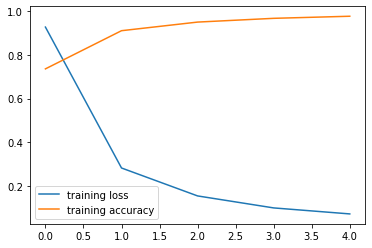

In [14]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

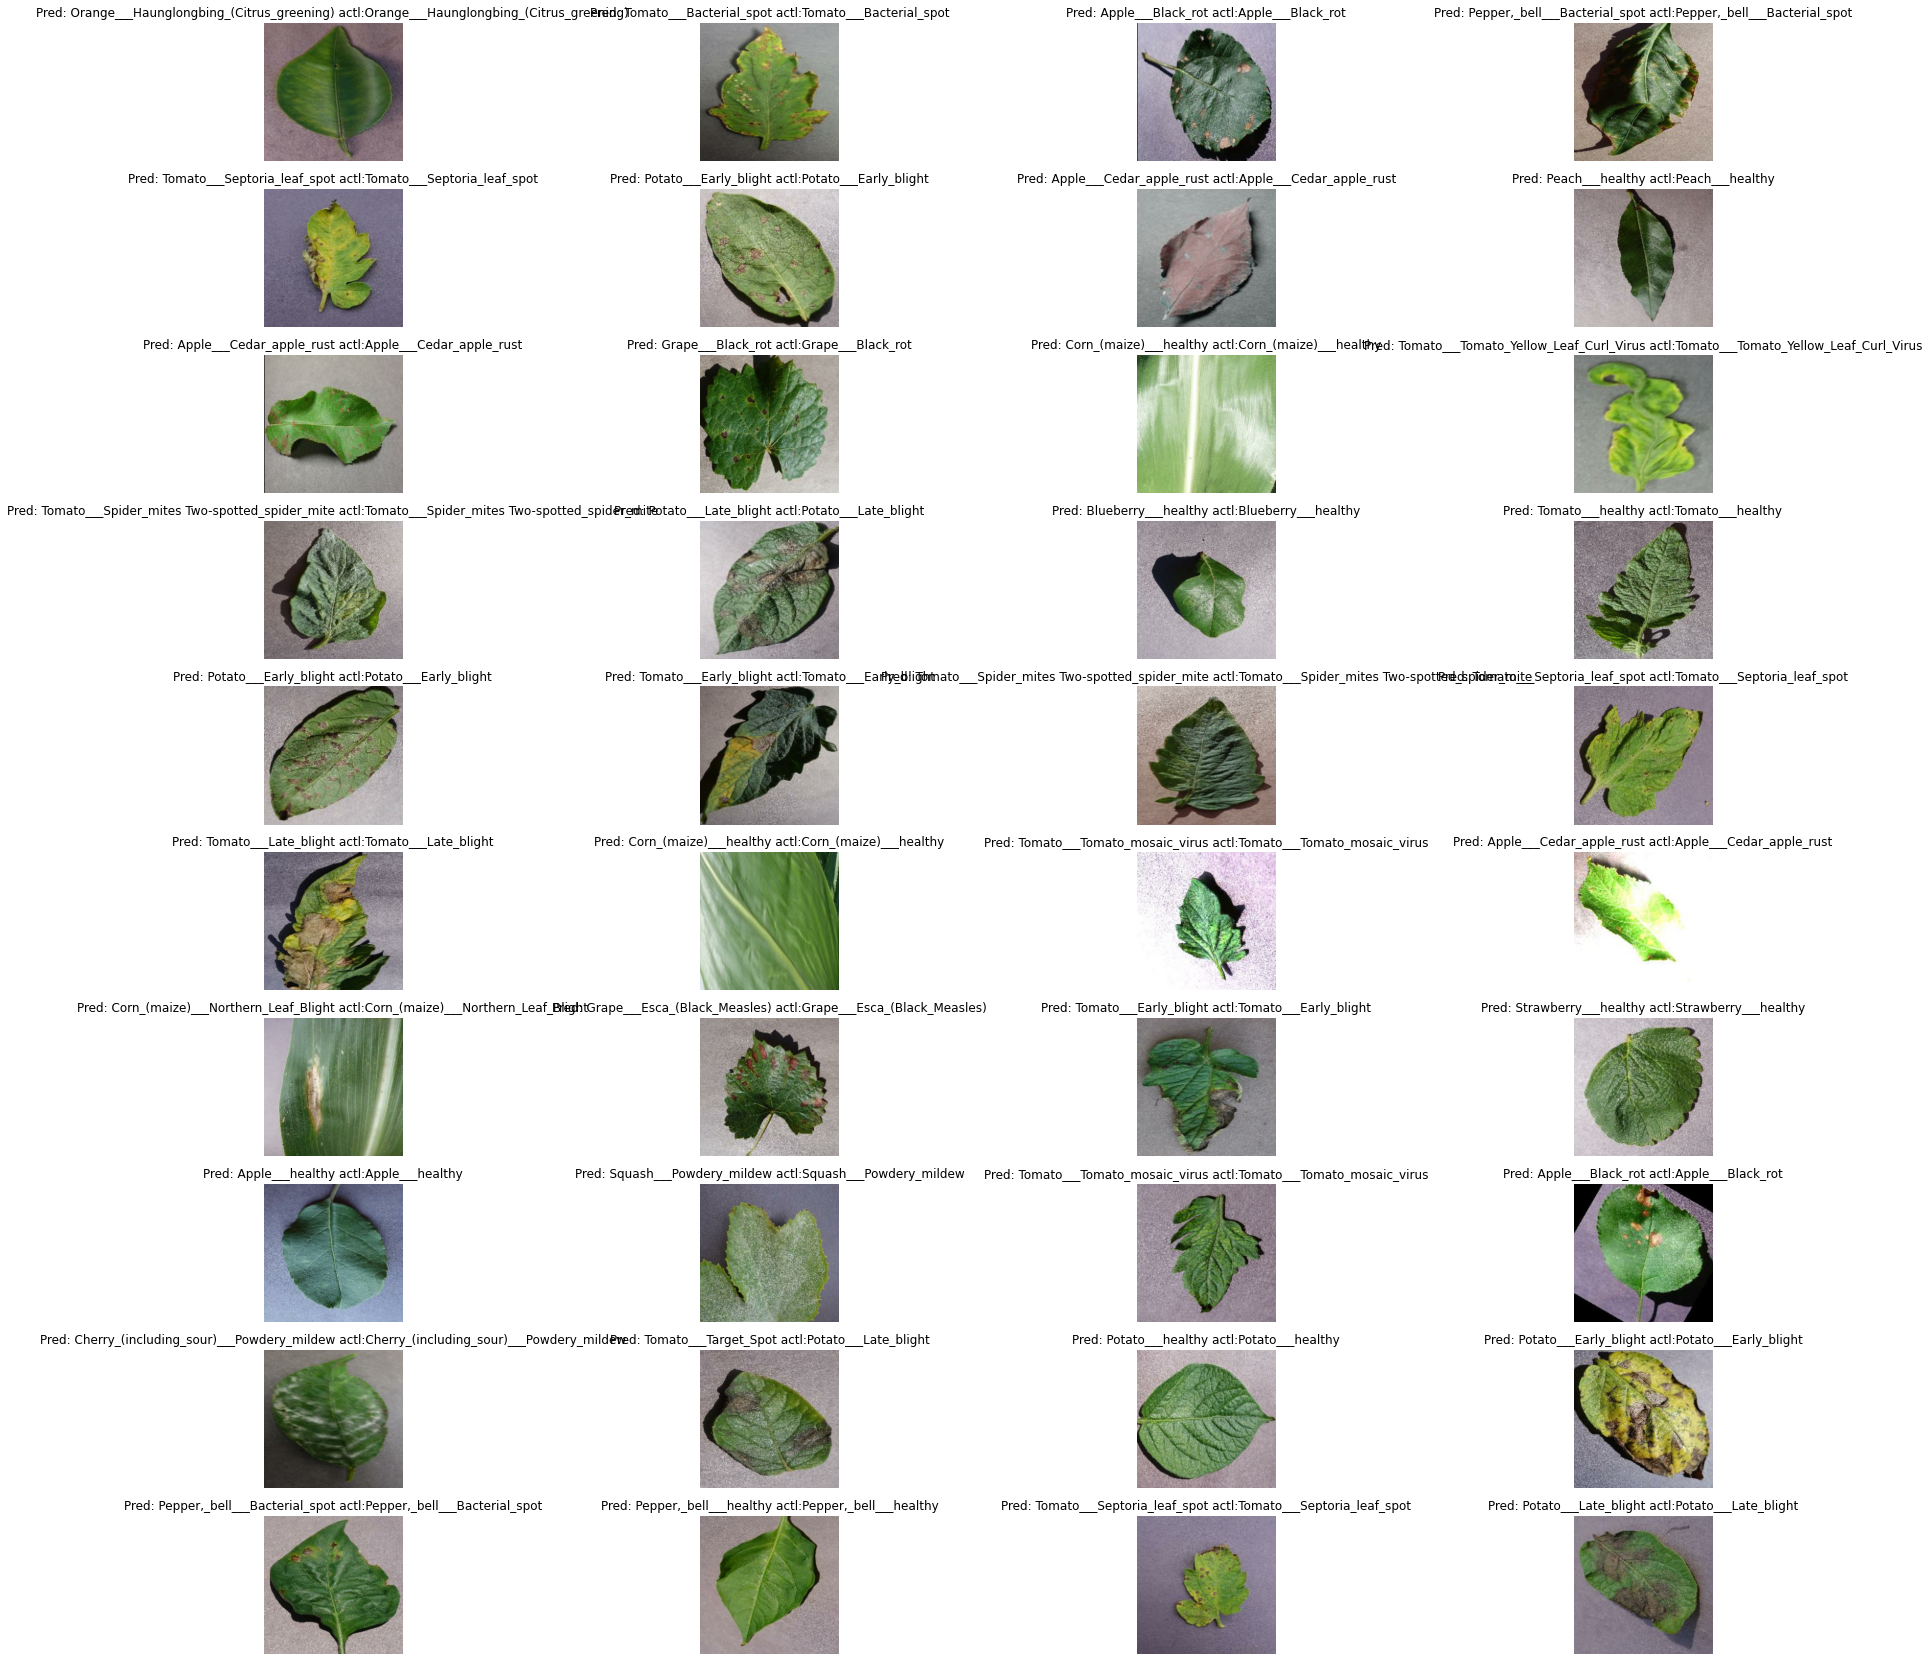

In [15]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in validation_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

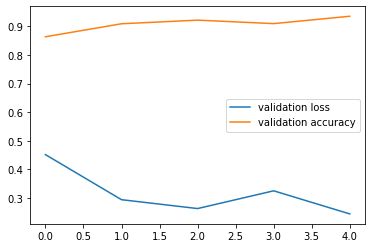

In [16]:
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

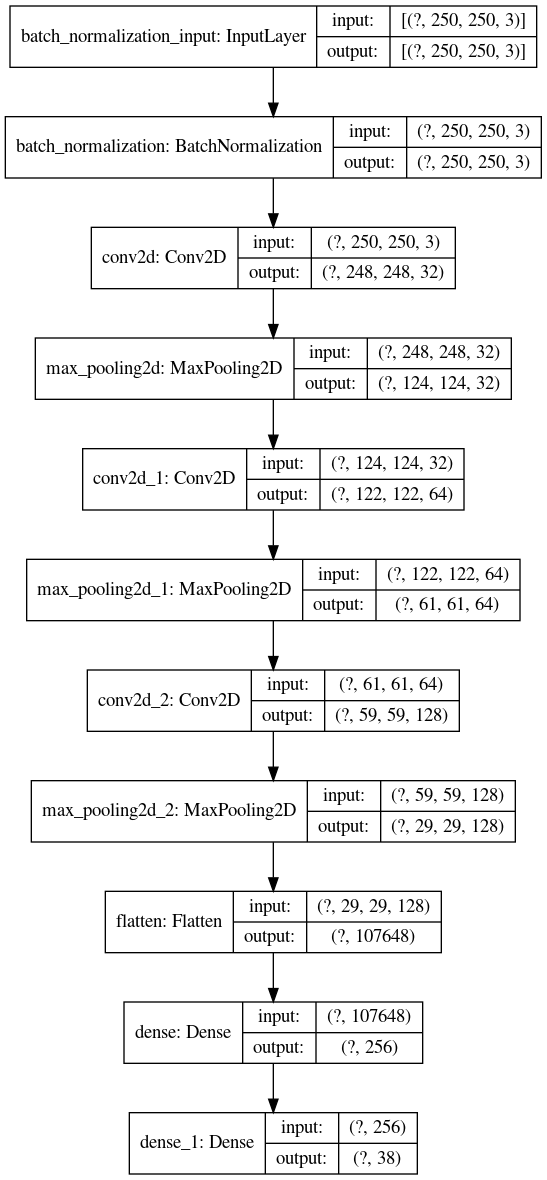

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(MyCnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
MyCnn.save('model.h5')

In [19]:
#time taken for validation
start = perf_counter() 
_, unPrunnedAccuracy = MyCnn.evaluate(validation_ds, verbose = 0 )
end = perf_counter() 

sizeUnprunned = os.path.getsize('model.h5')
# let convert to MB
sizeUnprunned = sizeUnprunned / (1024 * 1024)

print ('unPrunned model Summary:')
print('Model size(MB) : {}'.format(sizeUnprunned))
print('Time on Validation data (sec) : {}'.format(end - start))
print('Accuracy on validation data: {}'.format(unPrunnedAccuracy))

unPrunned model Summary:
Model size(MB) : 316.61851501464844
Time on Validation data (sec) : 44.577026789
Accuracy on validation data: 0.9352948069572449


In [20]:
#weight pruning
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

epochs = 5
end_step = np.ceil(70295 / batch_size).astype(np.int32) * epochs
## pruning param
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=0, end_step=end_step)
                }
## defining prunned model
MyPrunnedModel = prune_low_magnitude(MyCnn, **pruning_params)
MyPrunnedModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [21]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir='.'),
]
retVal = MyPrunnedModel.fit(training_ds,validation_data= validation_ds,epochs = 5 ,callbacks= callbacks)

Epoch 1/5
703/703 [==============================] - 283s 403ms/step - loss: 0.0645 - accuracy: 0.9785 - val_loss: 0.2493 - val_accuracy: 0.9313
Epoch 2/5
703/703 [==============================] - 283s 403ms/step - loss: 0.0432 - accuracy: 0.9859 - val_loss: 0.2383 - val_accuracy: 0.9346
Epoch 3/5
703/703 [==============================] - 282s 401ms/step - loss: 0.0355 - accuracy: 0.9880 - val_loss: 0.2085 - val_accuracy: 0.9422
Epoch 4/5
703/703 [==============================] - 283s 403ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.2145 - val_accuracy: 0.9439
Epoch 5/5
703/703 [==============================] - 280s 398ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.2184 - val_accuracy: 0.9472


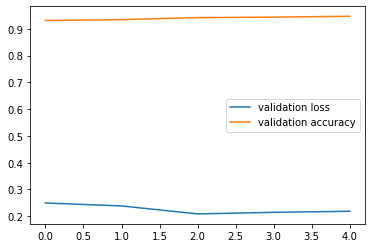

In [22]:

plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()


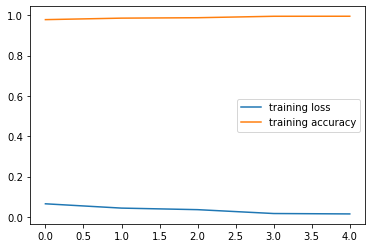

In [23]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

In [24]:
MyPrunnedModel.save('Prunnedmodel.h5')

In [27]:
start = perf_counter() 
_, PrunnedAccuracy = MyPrunnedModel.evaluate(validation_ds, verbose = 0 )
end = perf_counter() 

sizePrunned = os.path.getsize('Prunnedmodel.h5')
# let convert to MB
sizePrunned = sizePrunned / (1024 * 1024)

print ('Prunned model Summary:')
print('Model size(MB) : {}'.format(sizePrunned))
print('Time on Validation data (sec) : {}'.format(end - start))
print('Accuracy on validation data: {}'.format(PrunnedAccuracy))

Prunned model Summary:
Model size(MB) : 220.23455678
Time on Validation data (sec) : 34.12112345667
Accuracy on validation data: 0.9472455978393555
